In [1]:
import pickle
import numpy as np
import mysql.connector
import astropy.units as u
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee
import corner

from sdf import photometry
from sdf import filter
from sdf import model
from sdf import spectrum
from sdf import fitting
from sdf import analytics
from sdf import utils

%matplotlib notebook

In [2]:
mpl.rc('lines', linewidth=3)
mpl.rc('axes', linewidth=1)

In [3]:
with open('seds/51eri/sdb-v1-043736.13-022824.8-mnest/phoenix_m+modbb_disk_r_.pkl','rb') as f:
    r = pickle.load(f)
    
# refill these
mod,plmod = model.get_models(r.obs,r.model_comps)
r.models = mod
r.pl_models = plmod

lstar = r.star[0]['lstar']
tstar = r.comp_best_params[0][0]
parallax = r.star[0]['plx_arcsec']

In [4]:
params,sampler = fitting.run_emcee(r,nwalkers=500,nstep=1000)
temps = 10**params[:,4]
radii = np.sqrt(17.) * ( 278.3/temps )**2

/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


<IPython.core.display.Javascript object>


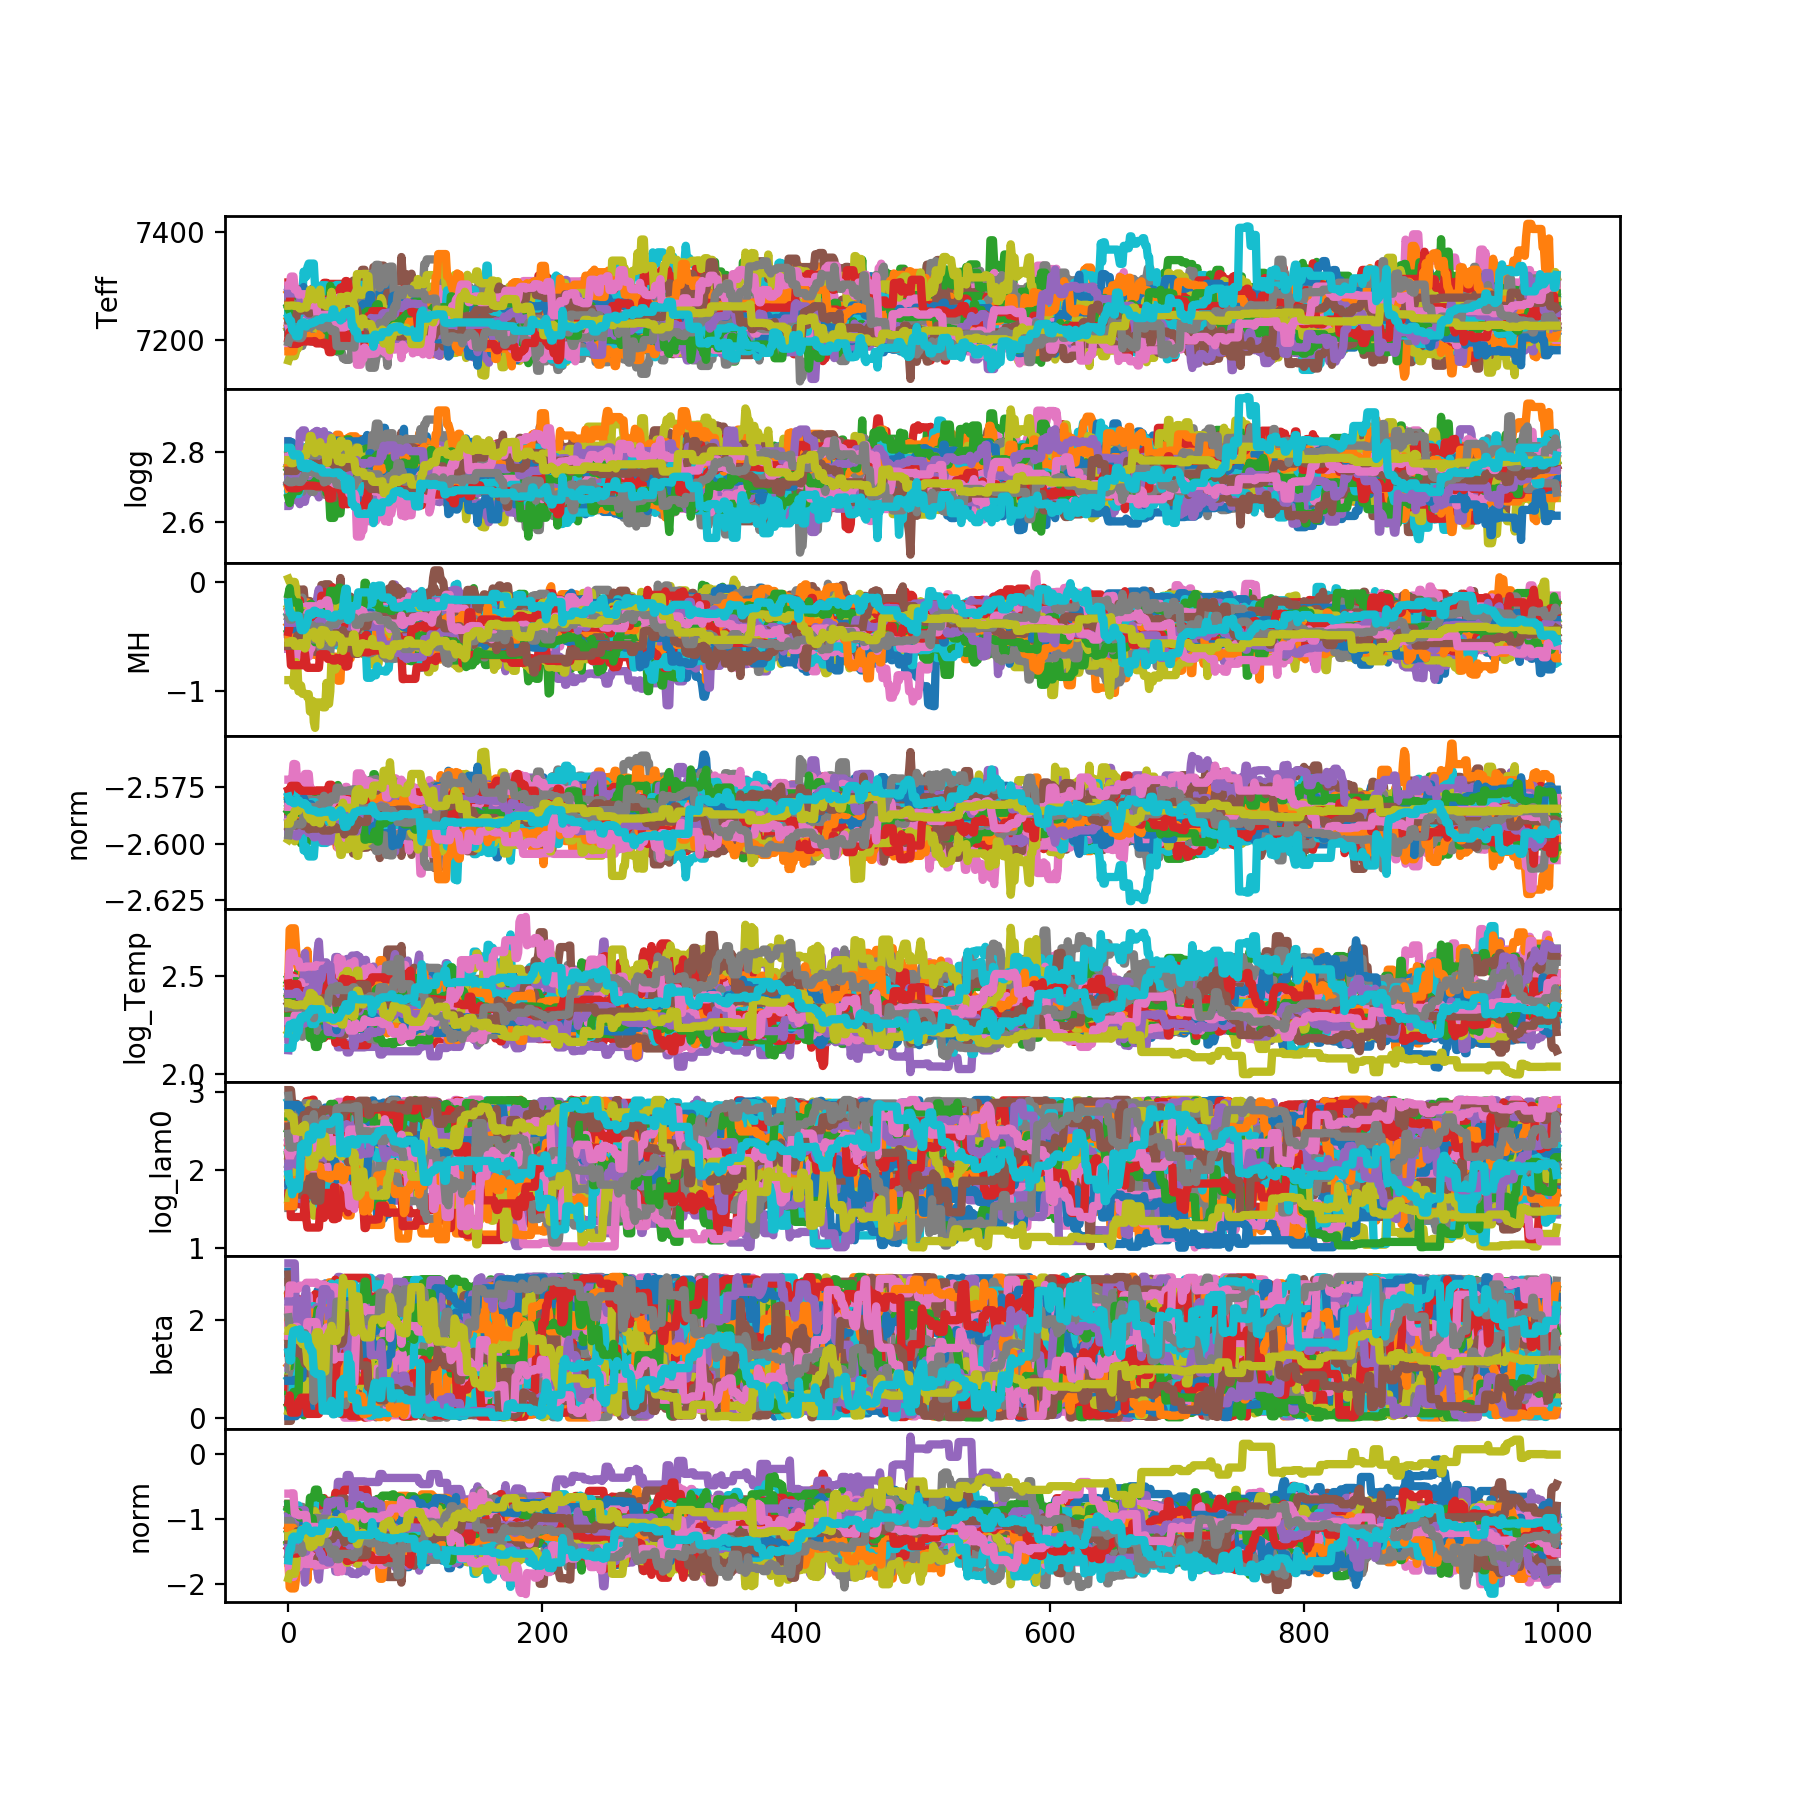

In [5]:
fig,ax = plt.subplots(r.model_info['ndim'],sharex=True,figsize=(9,9))

for i in range(r.model_info['ndim']):
    for j in range(50):
        ax[i].plot(sampler.chain[j,:,i])
        ax[i].set_ylabel(r.parameters[i])

fig.subplots_adjust(hspace=0)

<IPython.core.display.Javascript object>


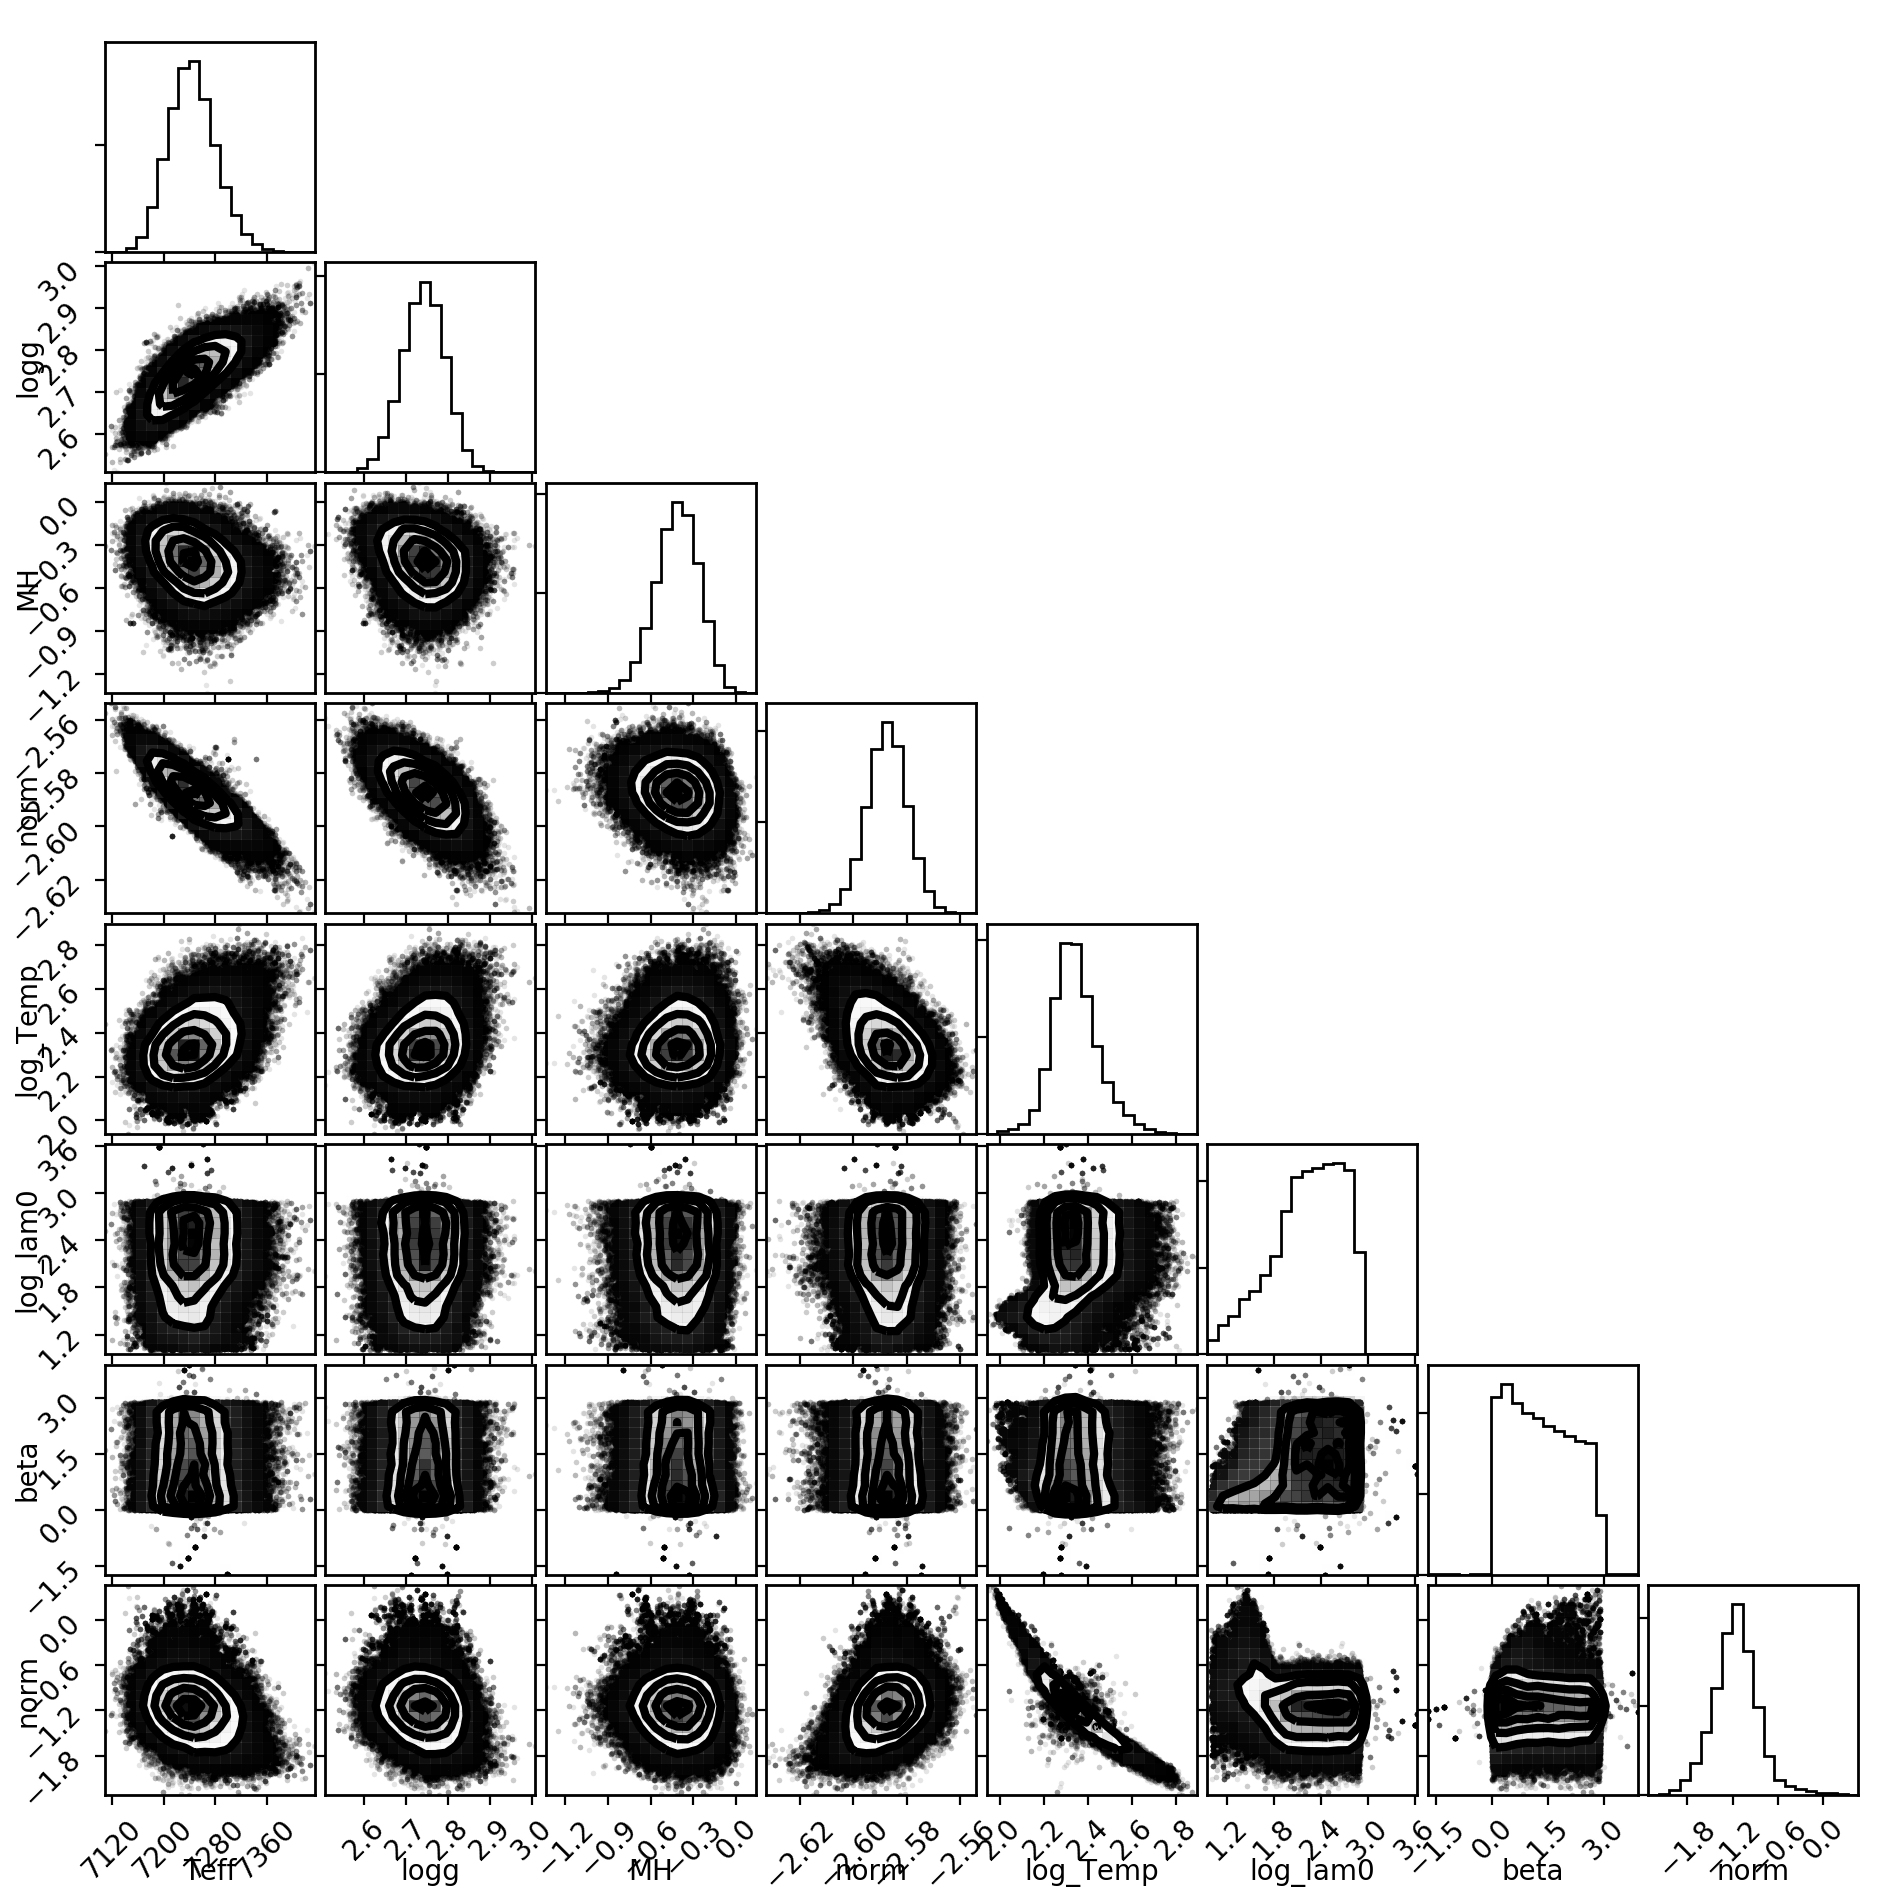

In [6]:
fig,ax = plt.subplots(r.model_info['ndim'],r.model_info['ndim'],figsize=(9.5,9.5))

_ = corner.corner(sampler.chain[:,:,:].reshape((-1, r.model_info['ndim'])),
                  fig=fig,labels=r.parameters)

<IPython.core.display.Javascript object>


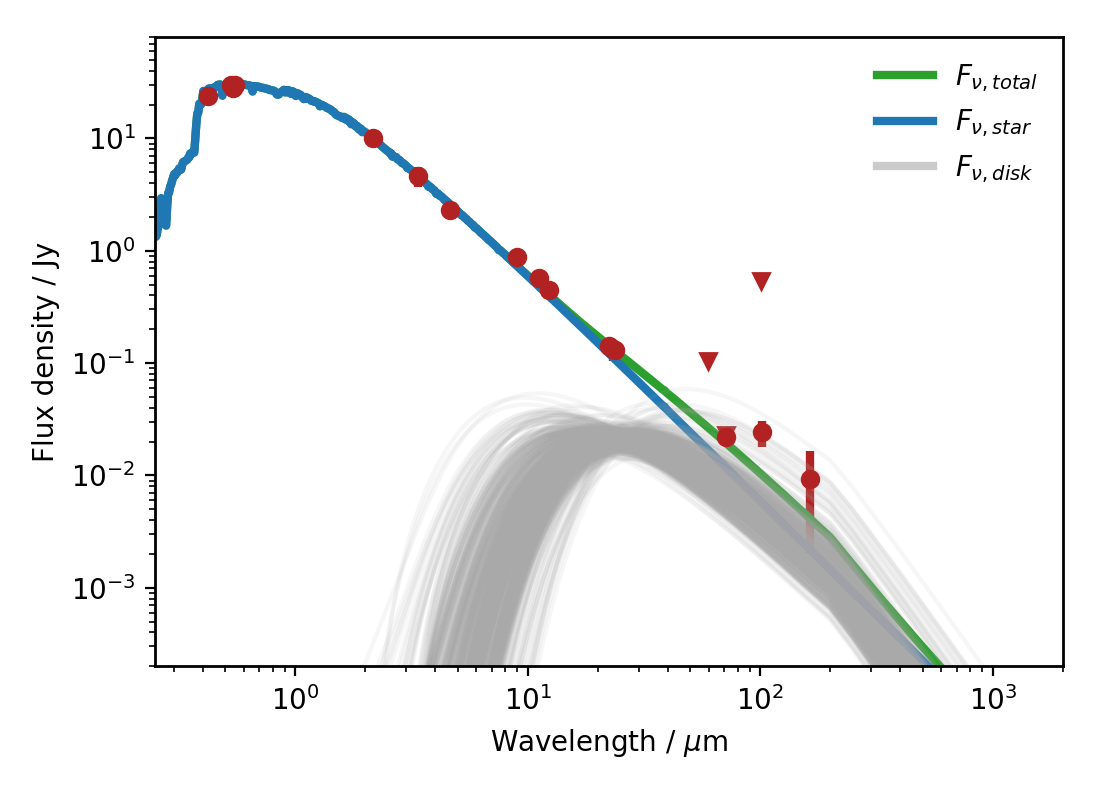

In [16]:
fig,ax = plt.subplots(figsize=(5.5,4))

# stellar and total spectra
ax.plot(r.total_spec.wavelength,r.total_spec.fnujy,color='C2',label='$F_{\\nu,total}$')
ax.loglog(r.comp_spectra[0].wavelength,r.comp_spectra[0].fnujy,label='$F_{\\nu,star}$')

# photometry
for p in r.obs:
    if not isinstance(p,photometry.Photometry):
        continue

    ok = np.invert(np.logical_or(p.upperlim,p.ignore))
    for i,f in enumerate(p.filters):
        if filter.iscolour(f):
            ok[i] = False

    ax.errorbar(p.mean_wavelength()[ok],p.fnujy[ok],yerr=p.e_fnujy[ok],
                fmt='o',color='firebrick')
    ok = np.logical_and(p.upperlim,np.invert(p.ignore))
    ax.plot(p.mean_wavelength()[ok],p.fnujy[ok],'v',color='firebrick')

# plot emcee samples
f880 = []
f1300 = []
ldisk_1pc = []
for par in sampler.chain[:,-1,:]:
    for m in r.pl_models[1]:
        if not isinstance(m,model.SpecModel):
            continue
        s = spectrum.ObsSpectrum(wavelength=m.wavelength,
                                 fnujy=m.fnujy([par[4],2.322,1,par[7]]))
        ax.plot(s.wavelength,s.fnujy,color='darkgrey',alpha=0.1,linewidth=1.5)
        
        s.fill_irradiance()
        ldisk_1pc.append(s.irradiance *4*np.pi*(u.pc.to(u.m))**2 / u.L_sun.to(u.W))
        f880.append(s.fnujy[486])
        f1300.append(s.fnujy[410])

ax.plot(-1,-1,color='darkgrey',alpha=0.6,label='$F_{\\nu,disk}$')

# sofia
# ax.plot([53,63,89,154,214],[.175,.199,.148,.115,.101],'--')

# alma
# ax.plot([880],[20e-6],'o',color='black')
# ax.plot([880],[200e-6],'o',color='black')
# ax.plot([880,880],[20e-6,200e-6],color='black')

ax.set_xlabel('Wavelength / $\mu$m')
ax.set_ylabel('Flux density / Jy')

ax.set_xlim(0.25,2e3)
ax.set_ylim(2e-4,80)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('sed_51eri.pdf')

<IPython.core.display.Javascript object>


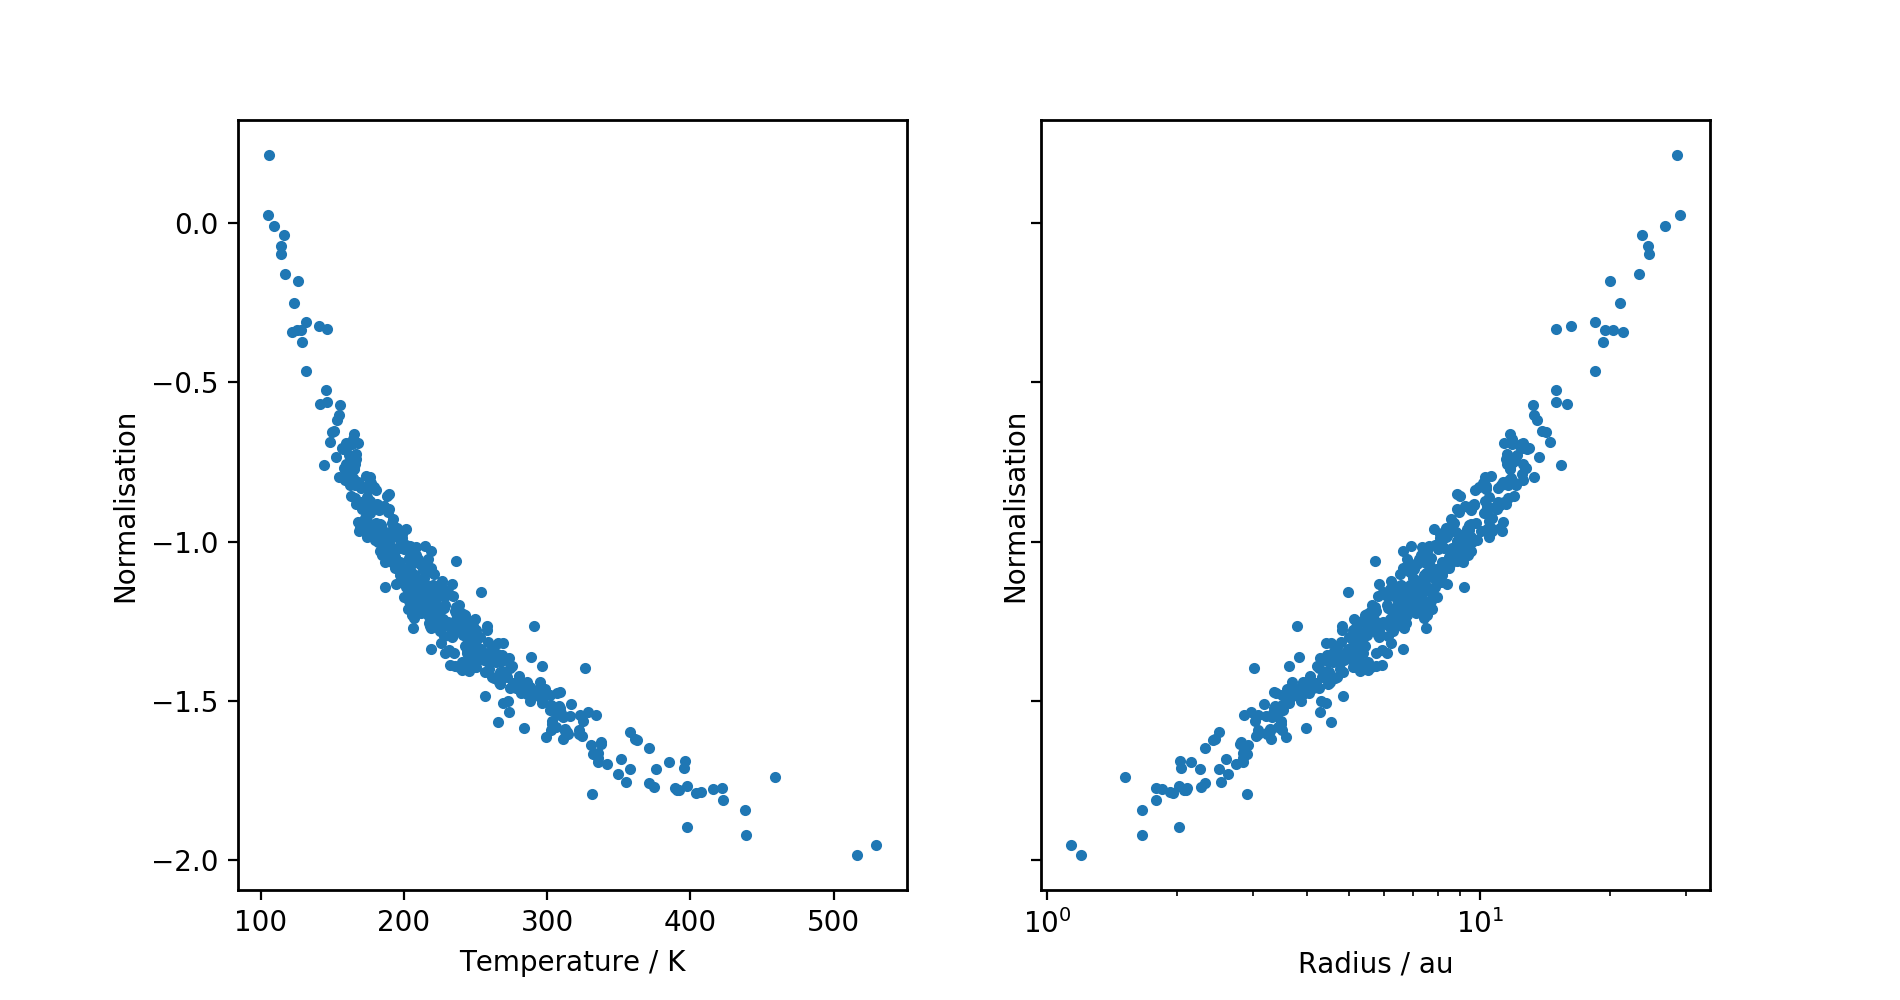

In [8]:
fig,ax = plt.subplots(1,2,figsize=(9.5,5),sharey=True)

ax[0].plot(temps,params[:,7],'.')
ax[0].set_xlabel('Temperature / K')
ax[0].set_ylabel('Normalisation')

ax[1].semilogx(radii,params[:,7],'.')
ax[1].set_xlabel('Radius / au')
ax[1].set_ylabel('Normalisation')

<IPython.core.display.Javascript object>


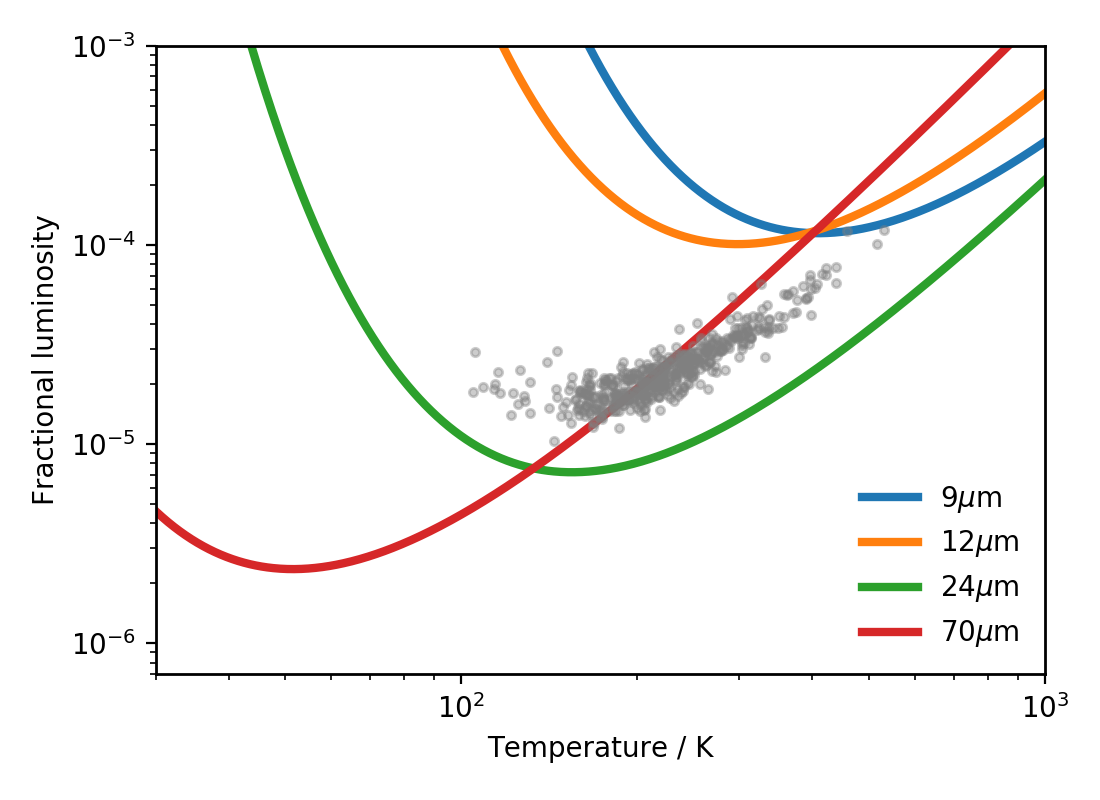

In [9]:
bb = analytics.BB_Disk(lstar=r.star[0]['lstar'],tstar=tstar,distance=1.0/parallax)
labels = ['$9\mu$m','$12\mu$m','$24\mu$m','$70\mu$m']
# lim = bb.f_limits(np.array([12,24,70]),
#                   stellar_flux=np.array(r.all_star_phot)[[70,80,81]],
#                   flux_limits=np.array([3*2e-2,999,3*3e-3]),
#                   r_limits=np.array([0.15,3*0.042,999]))
lim,_ = bb.f_limits_from_result(r,keep_filters=['AKARI9','WISE12','MIPS24','PACS70'])

fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.temperatures,lim[:,i],label=labels[i])
    
ldisk_lstar = np.array(ldisk_1pc) / parallax**2 / lstar
ax.plot(10**params[:,4],ldisk_lstar,'.',color='grey',alpha=0.4)

ax.set_xlabel('Temperature / K')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(30,1000)
ax.set_ylim(0.7e-6,1e-3)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_T_51eri.pdf')

<IPython.core.display.Javascript object>


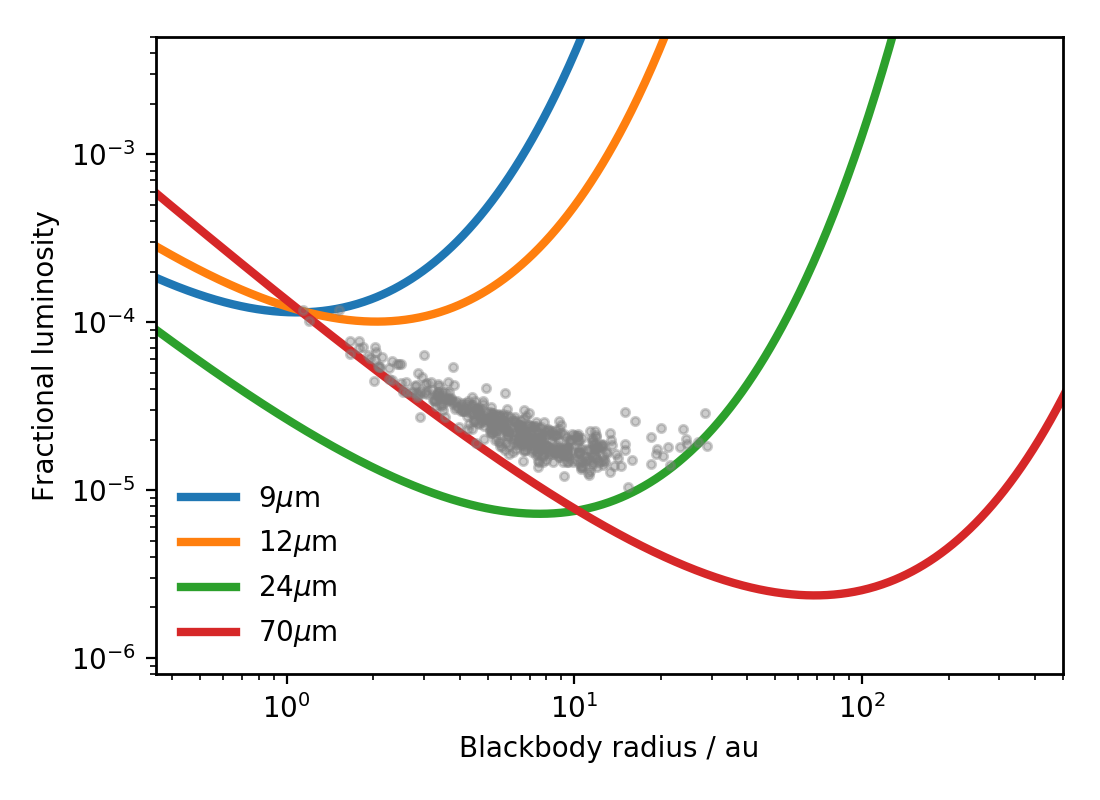

In [10]:
fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.blackbody_radii(),lim[:,i],label=labels[i])
    
ax.plot(radii,ldisk_lstar,'.',color='grey',alpha=0.4)

ax.set_xlabel('Blackbody radius / au')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(0.35,500)
ax.set_ylim(0.8e-6,5e-3)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_r_51eri.pdf')

# GJ 3305 AB

In [11]:
with open('seds/gj3305ab/sdb-v1-043737.47-022928.3-mnest/phoenix_m_.pkl','rb') as f:
    r1 = pickle.load(f)
    
# refill these
mod,plmod = model.get_models(r1.obs,r1.model_comps)
r1.models = mod
r1.pl_models = plmod

lstar1 = 0.155 # from Montet+15
tstar1 = r1.comp_best_params[0][0]
# parallax = r.star[0]['plx_arcsec'] # no parallax, so assume same as 51 Eri

<IPython.core.display.Javascript object>


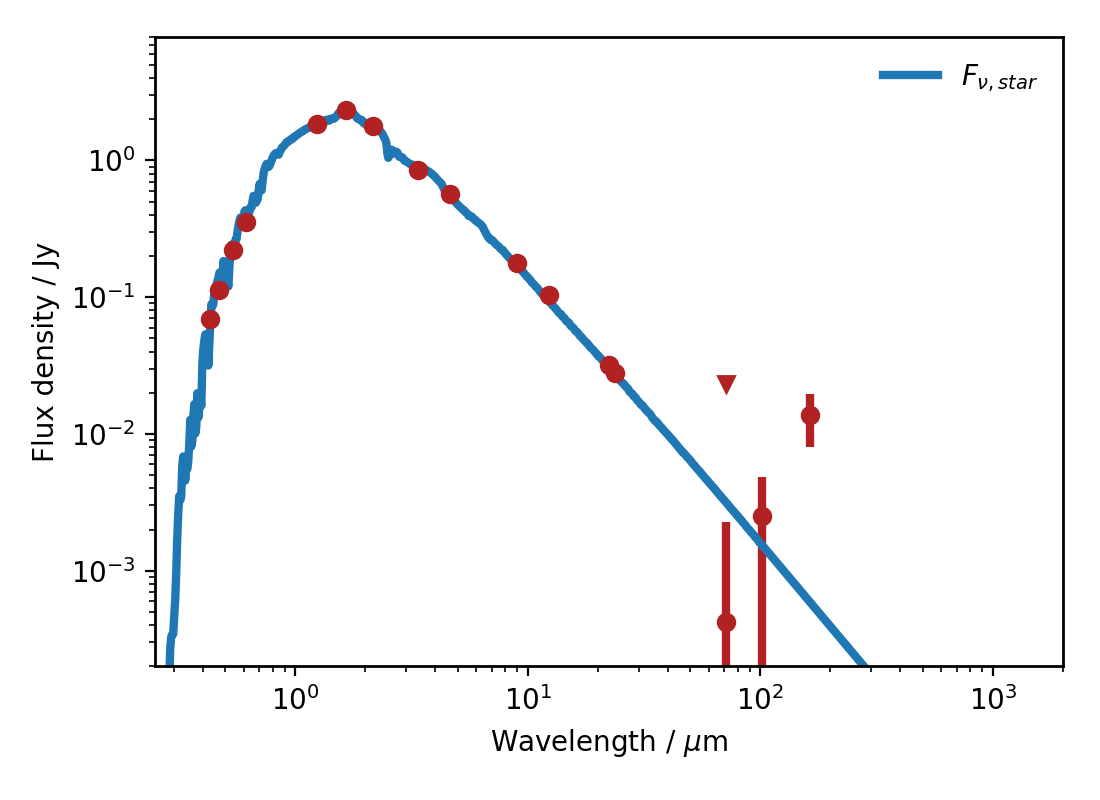

In [12]:
fig,ax = plt.subplots(figsize=(5.5,4))

# stellar spectrum
ax.loglog(r1.comp_spectra[0].wavelength,r1.comp_spectra[0].fnujy,label='$F_{\\nu,star}$')

ax.set_yscale("log", nonposy='clip')

# photometry
for p in r1.obs:
    if not isinstance(p,photometry.Photometry):
        continue

    ok = np.invert(np.logical_or(p.upperlim,p.ignore))
    for i,f in enumerate(p.filters):
        if filter.iscolour(f):
            ok[i] = False
    
    ax.errorbar(p.mean_wavelength()[ok],p.fnujy[ok],yerr=p.e_fnujy[ok],
                fmt='o',color='firebrick')
    ok = np.logical_and(p.upperlim,np.invert(p.ignore))
    ax.plot(p.mean_wavelength()[ok],p.fnujy[ok],'v',color='firebrick')

ax.set_xlabel('Wavelength / $\mu$m')
ax.set_ylabel('Flux density / Jy')

ax.set_xlim(0.25,2e3)
ax.set_ylim(2e-4,8)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('sed_gj3305.pdf')

<IPython.core.display.Javascript object>


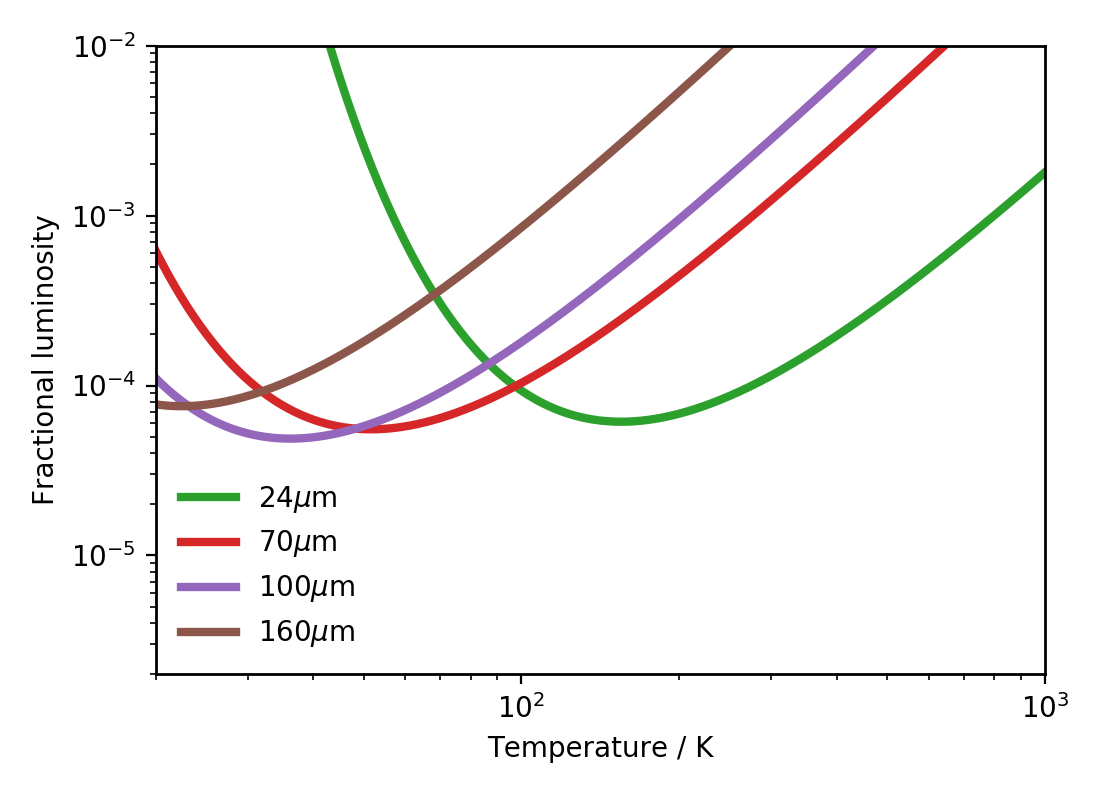

In [13]:
bb = analytics.BB_Disk(lstar=lstar1,tstar=tstar1,distance=1.0/parallax,
                       temperatures=10**np.linspace(0,3,1000))
labels = ['$24\mu$m','$70\mu$m','$100\mu$m','$160\mu$m']
lim,_ = bb.f_limits_from_result(r1,keep_filters=['MIPS24','PACS70','PACS100','PACS160'])
#                                 skip_filters=['AKARI9','WISE12','WISE22','MIPS70'])

cols = ['C2','C3','C4','C5']

fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.temperatures,lim[:,i],label=labels[i],color=cols[i])
    
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(20,1000)
ax.set_ylim(2e-6,1e-2)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_T_gj3305.pdf')

<IPython.core.display.Javascript object>


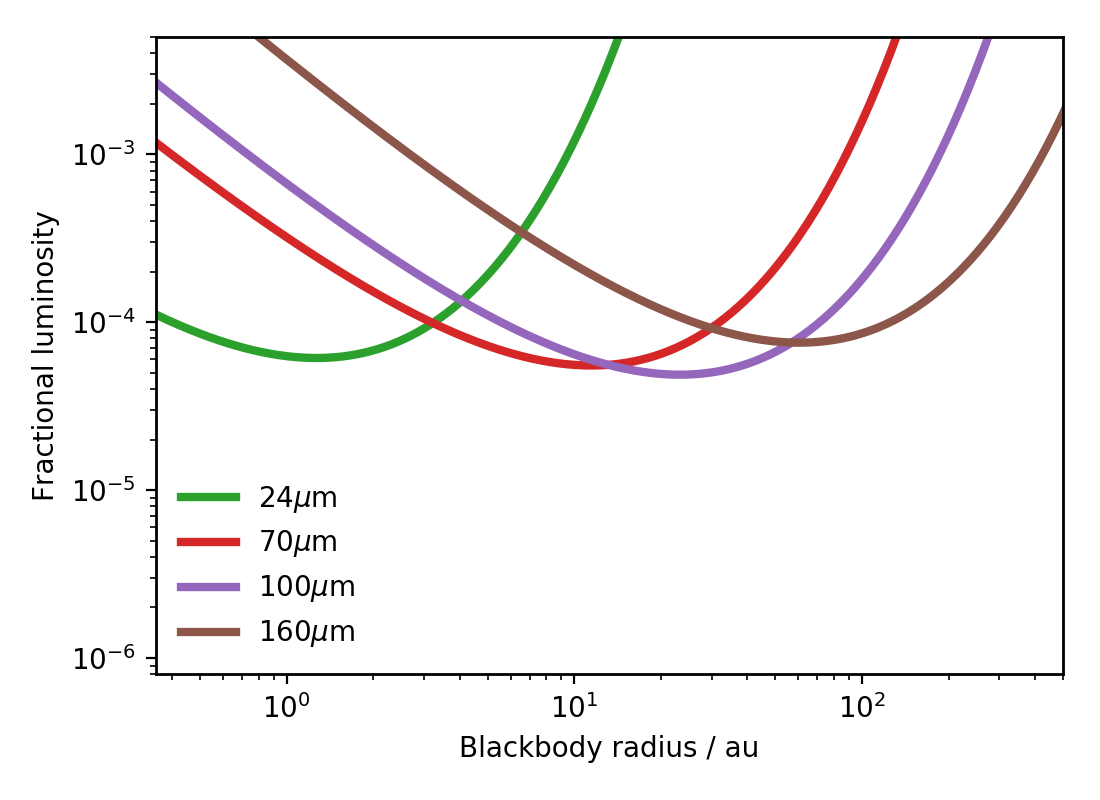

In [14]:
fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.blackbody_radii(),lim[:,i],label=labels[i],color=cols[i])
    
ax.set_xlabel('Blackbody radius / au')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(0.35,500)
ax.set_ylim(0.8e-6,5e-3)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_r_gj3305.pdf')